# Overview
TBD

# Setup
Let's get started by preparing your environment. We'll begin with authentication and configuration, which are required for all subsequent API calls.

## Package installs
Install all required Python packages. Run this cell only once after starting a new kernel.

In [ ]:
%pip install google google-cloud-retail google-cloud-storage google-cloud-bigquery pandas
%pip install google-cloud-aiplatform 
%pip install google-cloud-bigquery-storage pyarrow tqdm bigquery-magics
%pip install google-cloud-bigquery[pandas] jupyterlab
%pip install fsspec gcsfs
%pip install matplotlib seaborn plotly
%pip install --upgrade ipython-sql

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Authentication and GCP settings
Before we can interact with the Retail API, we need to authenticate with Google Cloud and set up our project context. This ensures all API calls are authorized and associated with the correct GCP project. If authentication fails, you'll be prompted to log in interactively. The `project_id` variable will be used throughout the notebook.

**About `project_id` and Application Default Credentials (ADC):**

- **`project_id`**: This uniquely identifies your Google Cloud project. All API requests, resource creation, and billing are tied to this project. Setting the correct `project_id` ensures your operations are performed in the intended environment and resources are properly tracked.

- **Application Default Credentials (ADC)**: ADC is a mechanism that allows your code to automatically find and use your Google Cloud credentials. Running the `gcloud auth application-default login` command sets up ADC by generating credentials that client libraries (like the Retail API) can use to authenticate API calls on your behalf.

**Why this matters:**  
Proper authentication and project selection are essential for secure, authorized access to Google Cloud resources. Without these, API calls will fail or may affect the wrong project. ADC simplifies credential management, especially in development and notebook environments.

In [1]:
import subprocess

try:
  # Try to get an access token
  subprocess.check_output(
    ['gcloud', 'auth', 'application-default', 'print-access-token'],
    stderr=subprocess.STDOUT
  )
  print("Already authenticated with Application Default Credentials.")
except subprocess.CalledProcessError:
  # If it fails, prompt for login
  print("No valid ADC found. Running interactive login...")
  !gcloud auth application-default login

Already authenticated with Application Default Credentials.


## Imports
Import all necessary libraries for API access, data analysis, and visualization.

In [4]:
from google.cloud.retail_v2 import SearchServiceClient, ProductServiceClient, PredictionServiceClient
from google.cloud.retail_v2.types import product, search_service, ListProductsRequest, SearchRequest, PredictRequest, UserEvent
from google.protobuf.field_mask_pb2 import FieldMask
from google.protobuf.json_format import MessageToDict
import pandas as pd
import http.client as http_client
import logging
import re
from IPython.display import display_html
from matplotlib import pyplot as plt
import seaborn as sns

# enabling BigQuery magics
%load_ext bigquery_magics

# configuring default optoins for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Global variables
With authentication complete, let's define some key variables that will be used in all our API calls. These include resource names and placements, which specify the context for search and recommendation requests.

**What is a 'placement'?**  
A placement is a configuration resource in the Retail API that determines how and where a model is used for serving search or recommendation results. Placements define the context (such as search, browse, or recommendation) and can be customized for different pages or user experiences.

**Why might you have multiple placements or branches?**  
- You may have different placements for various parts of your site or app, such as a homepage recommendation carousel, a category browse page, or a personalized search bar.
- Multiple branches allow you to manage different versions of your product catalog (e.g., staging vs. production, or A/B testing different product sets).

**Example scenarios:**
- Using a "default_search" placement for general product search, and a "recently_viewed_default" placement for showing users their recently viewed items.
- Having separate branches for testing new product data before rolling it out to all users, or for running experiments with different recommendation models.

In [5]:
import google.auth
import google.auth.exceptions

# Authenticate with Google Cloud and get the default project ID
try:
  credentials, project_id = google.auth.default()
  print(f"Using project ID: {project_id}")
  !gcloud auth application-default set-quota-project {project_id}
except google.auth.exceptions.DefaultCredentialsError:
  print("Google Cloud Authentication failed. Please configure your credentials.")
  print("You might need to run 'gcloud auth application-default login'")
  project_id = None # Set to None or a default
  
  
# Define the default placement for search and recommendations
DEFAULT_SEARCH = (
  f"projects/{project_id}/locations/global/catalogs/default_catalog/"
  "placements/default_search" # Use default_search unless you have a specific browse placement
)
RECENTLY_VIEWED_DEFAULT = (
  f"projects/{project_id}/locations/global/catalogs/default_catalog/"
  "placements/recently_viewed_default"
)
DEFAULT_BRANCH = f"projects/{project_id}/locations/global/catalogs/default_catalog/branches/0"

Using project ID: artilekt-vaisc-csb

Credentials saved to file: [/home/volenin/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "artilekt-vaisc-csb" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.

Credentials saved to file: [/home/volenin/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "artilekt-vaisc-csb" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


## Utils
To make our analysis easier, we'll use some utility functions for data conversion and HTTP logging. These will help us convert API responses to Pandas DataFrames for analysis and enable detailed logging for troubleshooting.

In [6]:
import pandas as pd
from google.protobuf.json_format import MessageToDict

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def json2df(products_list):
  if products_list:
    products_dicts = [dict(sorted(MessageToDict(p._pb).items())) for p in products_list]
    df = pd.json_normalize(products_dicts)
    return df
  else:
    print("No products returned or an error occurred.")
    return pd.DataFrame()

from contextlib import contextmanager

@contextmanager
def http_logging(log_http: bool):
    """
    Context manager to enable/disable HTTP logging for Google API clients.
    Usage:
        with http_logging(log_http):
            # code that needs HTTP logging
    """
    import http.client as http_client
    import logging
    root_logger = logging.getLogger()
    original_http_debuglevel = http_client.HTTPConnection.debuglevel
    original_log_level = root_logger.level
    try:
        if log_http:
            print("\n--- [INFO] Enabling HTTP Logging (forcing REST transport) ---")
            logging.basicConfig()
            root_logger.setLevel(logging.DEBUG)
            http_client.HTTPConnection.debuglevel = 1
            print("--- [INFO] Using REST transport. ---")
        yield
    finally:
        if log_http:
            http_client.HTTPConnection.debuglevel = original_http_debuglevel
            root_logger.setLevel(original_log_level)
            print("--- [INFO] HTTP Logging & Root Log Level Restored ---")

# Data Analysis

Now that our environment is set up, let's start analyzing the product data. We'll fetch data from BigQuery, examine product titles, and use Generative AI to extract brand information.

## Fetch Product Data from BigQuery

First, let's connect to BigQuery and fetch product data from the `retail.products` table. We'll focus on the `title` field to understand how product names are structured and what brand information we can extract.

In [8]:
# Set up BigQuery client and fetch product data
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

# Query to fetch product titles and IDs
query = f"""
SELECT 
    id,
    title,
    categories
FROM `{project_id}.retail.products`
WHERE title IS NOT NULL
# LIMIT 1000
"""

print(f"Fetching product data from {project_id}.retail.products...")
df_products = client.query(query).to_dataframe()
print(f"Fetched {len(df_products)} products")
display(df_products.head(10))

Fetching product data from artilekt-vaisc-csb.retail.products...
Fetched 1268 products
Fetched 1268 products


,id,title,categories
0,GGOEGBJA127699,Google Mural Tote,[Bags]
1,GGOEGBJH124599,Google Seaport Tote,[Bags]
2,GGOEGBRC128099,Google Incognito Zippack V2,[Bags]
3,GGOEGBRC128199,Google Incognito Laptop Organizer V2,[Bags]
4,GGOEGBJC100199,Google Mesh Bag Blue,[Bags]
5,GGCOGBJC100999,#IamRemarkable Tote,[Bags]
6,GGOEGBBC122499,Google Campus Bike Carry Pouch,[Bags]
7,GGOEGBBJ131999,Google Cork Pencil Pouch,[Bags]
8,GGOEGBJC122399,Google Campus Bike Tote Navy,[Bags]
9,GGOEGBJD133999,Google Cambridge Campus Tote,[Bags]


## Analyze Product Titles

Let's examine the structure and patterns in product titles to understand what brand information might be embedded within them.

In [10]:
# Basic analysis of product titles
print("=== Product Title Analysis ===")
print(f"Total products: {len(df_products)}")
print(f"Unique titles: {df_products['title'].nunique()}")
print(f"Average title length: {df_products['title'].str.len().mean():.1f} characters")


# Display some sample titles
print("\n=== Sample Product Titles ===")
sample_titles = df_products['title'].sample(10).tolist()
for i, title in enumerate(sample_titles, 1):
    print(f"{i:2}. {title}")

# Check title length distribution
title_lengths = df_products['title'].str.len()
print(f"\n=== Title Length Statistics ===")
print(f"Min length: {title_lengths.min()}")
print(f"Max length: {title_lengths.max()}")
print(f"Median length: {title_lengths.median()}")

=== Product Title Analysis ===
Total products: 1268
Unique titles: 451
Average title length: 27.7 characters

=== Sample Product Titles ===
 1. Nest Detect - USA
 2. Google Land & Sea French Terry Sweatshirt
 3. Google Unisex Eco Tee Black
 4. Google Zip Hoodie F/C
 5. Android Iconic Hat White
 6. Stan and Friends 2019 Youth Tee
 7. Google Laptop and Cell Phone Stickers
 8. Google Black Cloud Zip Hoodie
 9. Google Crewneck Sweatshirt Navy
10. Google Navy Speckled Tee

=== Title Length Statistics ===
Min length: 12
Max length: 43
Median length: 28.0


## Visualize Title Patterns

Let's create some visualizations to better understand the data patterns.

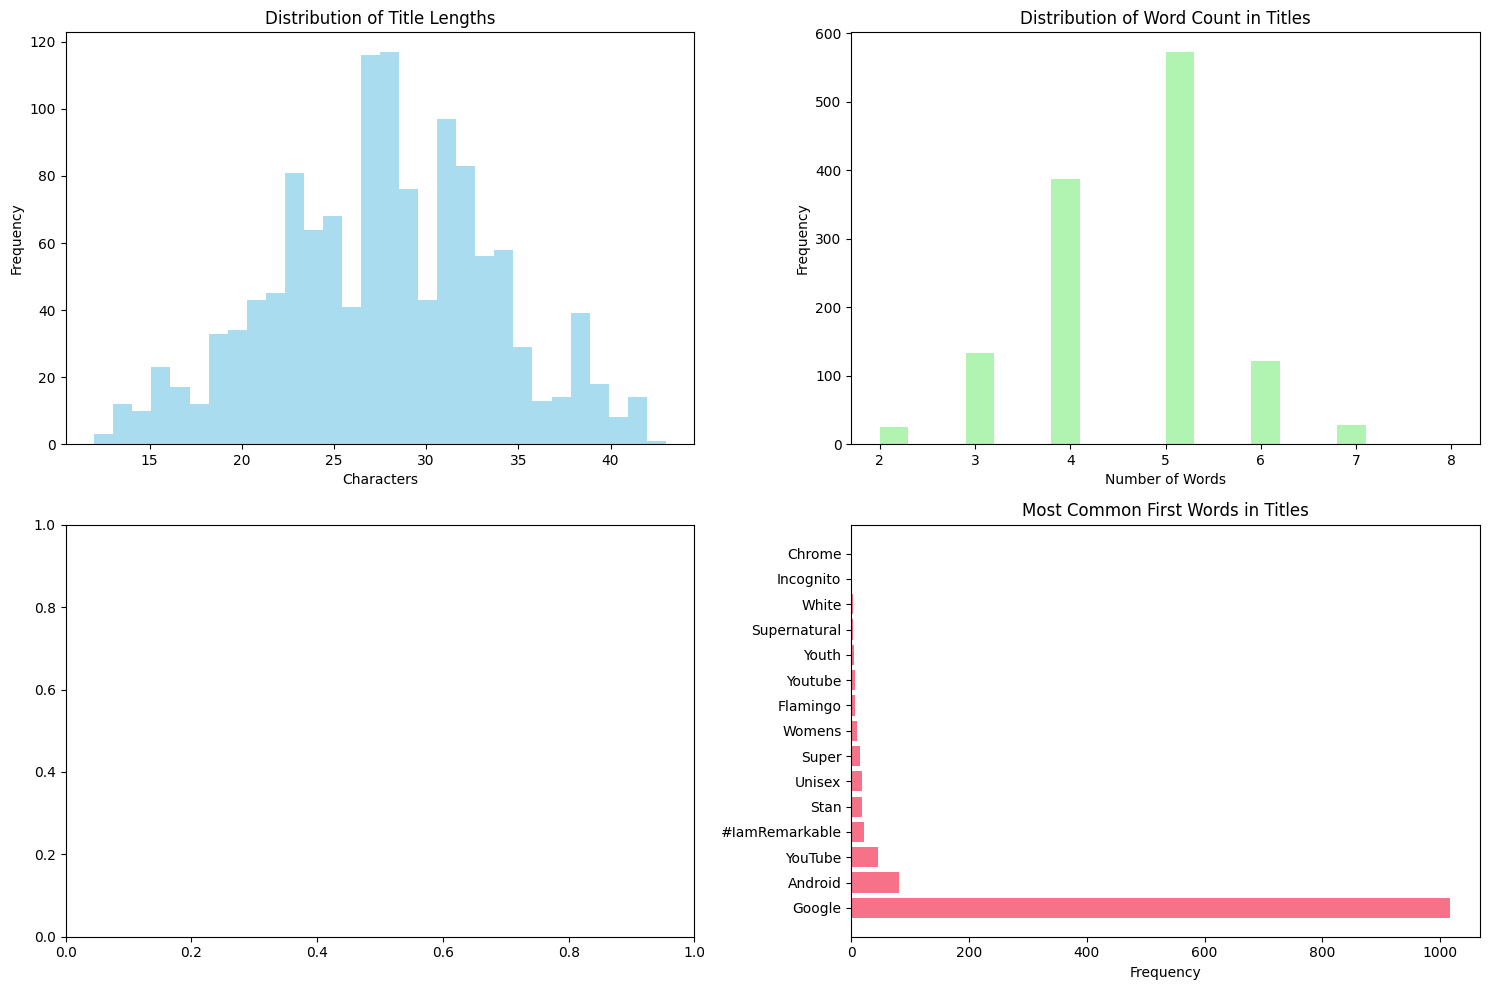


=== Top 20 First Words in Titles ===


title
Google            1017
Android             81
YouTube             46
#IamRemarkable      21
Stan                19
Unisex              19
Super               15
Womens              10
Flamingo             7
Youtube              7
Youth                5
Supernatural         3
White                3
Incognito            2
Chrome               2
Name: count, dtype: int64

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Title length distribution
axes[0, 0].hist(df_products['title'].str.len(), bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Title Lengths')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')

# 2. Word count distribution
word_counts = df_products['title'].str.split().str.len()
axes[0, 1].hist(word_counts, bins=20, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution of Word Count in Titles')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')


# 4. Most common first words in titles (potential brand indicators)
first_words = df_products['title'].str.split().str[0].value_counts().head(15)
axes[1, 1].barh(range(len(first_words)), first_words.values)
axes[1, 1].set_yticks(range(len(first_words)))
axes[1, 1].set_yticklabels(first_words.index)
axes[1, 1].set_title('Most Common First Words in Titles')
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n=== Top 20 First Words in Titles ===")
display(first_words.head(20))

## Use Generative AI for Brand Extraction

Now let's use Vertex AI's Generative AI capabilities to extract brand information from product titles. We'll use the Gemini model to analyze titles and identify potential brands.

In [14]:

import vertexai
from vertexai.generative_models import GenerativeModel
import json
import time
from tqdm import tqdm

# Initialize Vertex AI
vertexai.init(project=project_id, location="us-central1")

# Initialize the Gemini model
model = GenerativeModel("gemini-2.0-flash")

def extract_brands_with_ai(titles_batch, batch_size=10):
    """
    Extract brands from a batch of product titles using Generative AI
    """
    
    # Create prompt for brand extraction
    prompt = f"""
    You are an expert in e-commerce product data analysis. Your task is to extract brand names from product titles.
    
    Rules:
    1. Extract only actual brand names, not product types or categories
    2. Common brands include: Google, Apple, Nike, Adidas, Samsung, etc.
    3. If no clear brand is identifiable, return "Unknown"
    4. Return only the brand name, nothing else
    5. Be consistent with brand name formatting (e.g., "Google" not "google")
    
    Product titles to analyze:
    {chr(10).join([f"{i+1}. {title}" for i, title in enumerate(titles_batch)])}
    
    Return your response as a JSON array with one brand per title, in the same order:
    ["Brand1", "Brand2", "Unknown", ...]
    """
    
    try:
        response = model.generate_content(prompt)
        # Parse the JSON response
        brands = json.loads(response.text.strip())
        return brands
    except Exception as e:
        print(f"Error processing batch: {e}")
        return ["Error"] * len(titles_batch)

# Process titles in batches
print("=== Extracting Brands using Generative AI ===")
batch_size = 5  # Small batch size to avoid API limits
all_extracted_brands = []

# Take a sample of titles for demonstration (adjust size as needed)
sample_df = df_products.sample(n=min(50, len(df_products)))  # Sample 50 products
sample_titles = sample_df['title'].tolist()

print(f"Processing {len(sample_titles)} product titles in batches of {batch_size}...")

for i in tqdm(range(0, len(sample_titles), batch_size)):
    print(f"Processing batch {i // batch_size + 1}...")
    batch = sample_titles[i:i+batch_size]
    extracted_brands = extract_brands_with_ai(batch)
    all_extracted_brands.extend(extracted_brands)
    
    # Add small delay to respect API rate limits
    time.sleep(1)

# Add extracted brands to our sample dataframe
sample_df = sample_df.copy()
sample_df['ai_extracted_brand'] = all_extracted_brands

print("Brand extraction completed!")

524.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.
=== Extracting Brands using Generative AI ===
=== Extracting Brands using Generative AI ===
Processing 50 product titles in batches of 5...
Processing 50 product titles in batches of 5...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing batch 1...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 10%|█         | 1/10 [08:24<1:15:39, 504.41s/it]

Processing batch 2...


Traceback (most recent call last):
  File "_pydevd_bundle\\pydevd_cython.pyx", line 1609, in _pydevd_bundle.pydevd_cython.handle_exception
  File "/c/Projects/Lab/vaisc/vaisc-csb/.venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2188, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, trace_suspend_type, from_this_thread, frames_tracker)
  File "/c/Projects/Lab/vaisc/vaisc-csb/.venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2257, in _do_wait_suspend
    notify_event.wait(wait_timeout)
  File "/usr/lib/python3.9/threading.py", line 574, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.9/threading.py", line 316, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt


Error processing batch: Expecting value: line 1 column 1 (char 0)


 20%|██        | 2/10 [32:04<2:19:03, 1042.91s/it]

Processing batch 3...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 30%|███       | 3/10 [32:05<1:06:12, 567.45s/it] 

Processing batch 4...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 40%|████      | 4/10 [32:07<34:24, 344.04s/it]  

Processing batch 5...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 50%|█████     | 5/10 [32:09<18:22, 220.53s/it]

Processing batch 6...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 60%|██████    | 6/10 [32:10<09:44, 146.05s/it]

Processing batch 7...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 70%|███████   | 7/10 [32:11<04:56, 98.77s/it] 

Processing batch 8...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 80%|████████  | 8/10 [32:13<02:15, 67.78s/it]

Processing batch 9...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


 90%|█████████ | 9/10 [32:14<00:47, 47.04s/it]

Processing batch 10...
Error processing batch: Expecting value: line 1 column 1 (char 0)
Error processing batch: Expecting value: line 1 column 1 (char 0)


100%|██████████| 10/10 [32:16<00:00, 193.62s/it]

Brand extraction completed!


## Analyze AI-Extracted Brand Results

Let's examine the results of our AI-powered brand extraction and compare them with existing brand information.

In [ ]:
# Display results
print("=== AI Brand Extraction Results ===")
print(f"Processed {len(sample_df)} products")

# Show sample results
print("\n=== Sample Results ===")
comparison_df = sample_df[['title', 'brands', 'ai_extracted_brand']].head(15)
display(comparison_df)

# Analyze extracted brands
print("\n=== Extracted Brand Statistics ===")
brand_counts = sample_df['ai_extracted_brand'].value_counts()
print(f"Unique brands extracted: {len(brand_counts)}")
print(f"Products with 'Unknown' brand: {brand_counts.get('Unknown', 0)}")

print("\n=== Top 10 Extracted Brands ===")
display(brand_counts.head(10))

# Compare with existing brand data
products_with_existing_brands = sample_df['brands'].notna().sum()
products_with_ai_brands = (sample_df['ai_extracted_brand'] != 'Unknown').sum()

print(f"\n=== Comparison ===")
print(f"Products with existing brand info: {products_with_existing_brands}")
print(f"Products with AI-extracted brands: {products_with_ai_brands}")
print(f"Improvement: {products_with_ai_brands - products_with_existing_brands} additional products with brand info")

## Visualize Brand Extraction Results

Let's create visualizations to better understand our brand extraction results.

In [ ]:
# Create visualizations for brand extraction results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top extracted brands
top_brands = sample_df['ai_extracted_brand'].value_counts().head(10)
axes[0, 0].barh(range(len(top_brands)), top_brands.values)
axes[0, 0].set_yticks(range(len(top_brands)))
axes[0, 0].set_yticklabels(top_brands.index)
axes[0, 0].set_title('Top 10 AI-Extracted Brands')
axes[0, 0].set_xlabel('Number of Products')

# 2. Brand extraction success rate
success_counts = (sample_df['ai_extracted_brand'] != 'Unknown').value_counts()
labels = ['Brand Identified', 'Unknown Brand']
colors = ['lightgreen', 'lightcoral']
axes[0, 1].pie(success_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
axes[0, 1].set_title('Brand Extraction Success Rate')

# 3. Comparison of existing vs AI brands
comparison_data = {
    'Has Existing Brand': products_with_existing_brands,
    'No Existing Brand': len(sample_df) - products_with_existing_brands,
    'AI Extracted Brand': products_with_ai_brands,
    'No AI Brand': len(sample_df) - products_with_ai_brands
}

x_pos = range(len(comparison_data))
axes[1, 0].bar(x_pos, comparison_data.values(), color=['blue', 'lightblue', 'green', 'lightgreen'])
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(comparison_data.keys(), rotation=45)
axes[1, 0].set_title('Brand Information: Existing vs AI-Extracted')
axes[1, 0].set_ylabel('Number of Products')

# 4. Title length vs brand extraction success
sample_df['title_length'] = sample_df['title'].str.len()
sample_df['brand_extracted'] = sample_df['ai_extracted_brand'] != 'Unknown'

# Create scatter plot
for extracted in [True, False]:
    subset = sample_df[sample_df['brand_extracted'] == extracted]
    label = 'Brand Extracted' if extracted else 'No Brand Extracted'
    color = 'green' if extracted else 'red'
    axes[1, 1].scatter(subset['title_length'], subset.index, 
                      alpha=0.6, label=label, color=color)

axes[1, 1].set_xlabel('Title Length (characters)')
axes[1, 1].set_ylabel('Product Index')
axes[1, 1].set_title('Title Length vs Brand Extraction Success')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Export Results and Summary

Let's save our analysis results and create a summary of findings.

In [ ]:
# Create comprehensive summary
print("=== PRODUCT DATA ANALYSIS SUMMARY ===")
print("\n1. Dataset Overview:")
print(f"   - Total products analyzed: {len(df_products)}")
print(f"   - Products with existing brand info: {df_products['brands'].notna().sum()}")
print(f"   - Average title length: {df_products['title'].str.len().mean():.1f} characters")

print("\n2. AI Brand Extraction Results (Sample):")
print(f"   - Sample size: {len(sample_df)}")
print(f"   - Brands successfully extracted: {products_with_ai_brands}")
print(f"   - Success rate: {(products_with_ai_brands/len(sample_df)*100):.1f}%")
print(f"   - Unique brands identified: {len(brand_counts)}")

print("\n3. Top Extracted Brands:")
for brand, count in brand_counts.head(5).items():
    print(f"   - {brand}: {count} products")

print("\n4. Recommendations:")
print("   - Use AI brand extraction to enrich product catalog")
print("   - Focus on products with longer, descriptive titles for better extraction")
print("   - Consider manual review of 'Unknown' classifications")
print("   - Implement brand standardization for consistency")

# Save results to CSV for further analysis
output_file = f"brand_extraction_results_{project_id}.csv"
sample_df.to_csv(output_file, index=False)
print(f"\n5. Results saved to: {output_file}")

# Display final comparison table
print("\n=== Final Results Sample ===")
final_display = sample_df[['title', 'brands', 'ai_extracted_brand']].head(10)
display(final_display)